In [243]:
import numpy as np
from qiskit import IBMQ
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error, amplitude_damping_error)

In [2]:
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [3]:
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


In [13]:
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


## Converting to and from QuantumChannel operator

In [14]:
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  9.74679434e-01+0.j]],

       [[ 0.00000000e+00+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -4.96506831e-17+0.j]]],
      input_dims=(2,), output_dims=(2,))


In [16]:
print(bit_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


## Noise Model

In [19]:
noise_model = NoiseModel()

error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


In [20]:
n_qubits = 4
circ = QuantumCircuit(n_qubits)
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


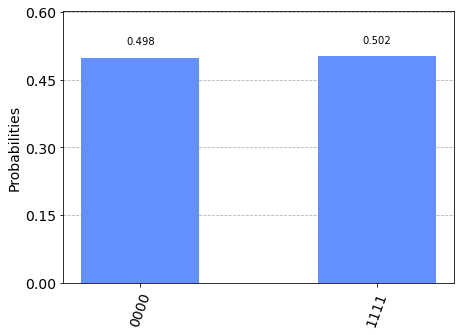

In [31]:
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts())

## Example 1: Basic bit-flip error noise model

In [251]:
def parse_noise_model_dict(nm_dict):
    # the qubits here are physical (p) qubits
    parsed = {}
    nm_list = nm_dict["errors"]
    for info in nm_list:
        for k, v in info.items():
            print('key:', k)
            print('val:', v)
        print('-----------')
#         val_dict = {
#             "type": info["type"],
#             "instructions": info.get("instructions", None),
#             "probabilities": info["probabilities"],
#         }
#         if info["operations"][0] not in parsed.keys():
#             parsed[info["operations"][0]] = {tuple(info["gate_qubits"][0]): val_dict}
#         elif tuple(info["gate_qubits"][0]) not in parsed[info["operations"][0]].keys():
#             parsed[info["operations"][0]][tuple(info["gate_qubits"][0])] = val_dict
#         else:
#             raise ValueError
    return parsed

In [254]:
# error probabilities
p_reset = 0.03
p_meas = 0.02
p_gate1 = 0.05
damp = 0.1

# QuantumError objects
amp_damping = amplitude_damping_error(damp)
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X', p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# add erros to noise model
noise_bit_flip = NoiseModel()
# noise_bit_flip.add_all_qubit_quantum_error(error_reset, 'reset')
# noise_bit_flip.add_all_qubit_quantum_error(amp_damping, ['h'])
# noise_bit_flip.add_all_qubit_quantum_error(error_meas, 'measure')
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ['u1', 'u2', 'u3'])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ['cx'])

print(noise_bit_flip)
nm_dict = noise_bit_flip.to_dict()
# print(nm_dict)

parsed_dict = parse_noise_model_dict(nm_dict)

# sim_noise = AerSimulator(noise_model=noise_bit_flip)
# circ_tnoise = transpile(circ, sim_noise)
# result_bit_flip = sim_noise.run(circ_tnoise).result()
# plot_histogram(result_bit_flip.get_counts())


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']
key: type
val: qerror
key: id
val: 787e5cda051d4bdf8ef12658df7b2547
key: operations
val: ['u1']
key: instructions
val: [[{'name': 'x', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]]
key: probabilities
val: [0.05, 0.95]
-----------
key: type
val: qerror
key: id
val: 787e5cda051d4bdf8ef12658df7b2547
key: operations
val: ['u2']
key: instructions
val: [[{'name': 'x', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]]
key: probabilities
val: [0.05, 0.95]
-----------
key: type
val: qerror
key: id
val: 787e5cda051d4bdf8ef12658df7b2547
key: operations
val: ['u3']
key: instructions
val: [[{'name': 'x', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]]
key: probabilities
val: [0.05, 0.95]
-----------
key: type
val: qerror
key: id
val: e2aa2c9a989541aca6c0e44538f81471
key: operations
val: ['cx']
key: instructions
val: [[{'name': 

## Example 2: T1/T2 thermal relaxation

In [256]:
# T1, T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4)   # 50 microseconds
T2s = np.random.normal(70e3, 10e3, 4)   # 70 microseconds
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# instructioni time (in nanoseconds)
time_u1 = 0
time_u2 = 50
time_u3 = 100
time_cx = 300
time_reset = 1000
time_measure = 1000

# quantumerror objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)]
errors_u1 = [thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)]
errors_u2 = [thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)]
errors_u3 = [thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(\
              thermal_relaxation_error(t1b, t2b, time_cx)) for t1a, t2a in zip(T1s, T2s)] for t1b, t2b in zip(T1s, T2s)]

noise_thermal = NoiseModel()
for j in range(4):
#     noise_thermal.add_quantum_error(errors_reset[j], 'reset', [j])
    noise_thermal.add_quantum_error(errors_measure[j], 'measure', [j])
    noise_thermal.add_quantum_error(errors_u1[j], 'u1', [j])
    noise_thermal.add_quantum_error(errors_u2[j], 'u2', [j])
    noise_thermal.add_quantum_error(errors_u3[j], 'u3', [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], 'cx', [j, k])

print(noise_thermal)
nm_dict = noise_thermal.to_dict()
parsed_dict = parse_noise_model_dict(nm_dict)


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]
key: type
val: qerror
key: id
val: ca15514299d94d679942bd971dd41ef6
key: operations
val: ['measure']
key: instructions
val: [[{'name': 'kraus', 'params': [array([[-0.99987916+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.98966017+0.j]]), array([[-0.01554532+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.01570584+0.j]]), array([[0.        +0.j, 0.14256956+0.j],
   

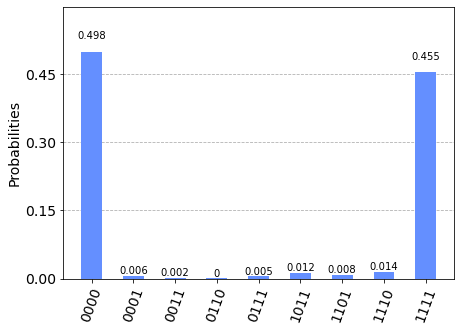

In [48]:
sim_thermal = AerSimulator(noise_model=noise_thermal)
circ_tthermal = transpile(circ, sim_thermal)
result_thermal = sim_thermal.run(circ_tthermal).result()
plot_histogram(result_thermal.get_counts())

In [56]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [65]:
IBMQ.save_account("8d15407d6c3cc7ec1b129cc5f1919d5ca1a90f1915173489cc44aaa1c2af1a2c8b5998bd15c6f6b8df937676ca3840529c4e163d7bdd2ee944a7ade0d6dc1904", overwrite=True)

In [68]:
provider = IBMQ.get_provider(hub="ibm-q")
type(provider)

qiskit.providers.ibmq.accountprovider.AccountProvider

In [111]:
backend = provider.get_backend('ibmq_quito')
noise_model = NoiseModel.from_backend(backend, thermal_relaxation=True)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'sx', 'reset', 'cx', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [112]:
nm_dict = noise_model.to_dict()
nm_list = nm_dict['errors']
print(nm_)

In [113]:
for info in nm_list:
    print(type(info))
    print(info)
    break

<class 'dict'>
{'type': 'qerror', 'id': '1142902a7c3e448da49c2f1a024d535c', 'operations': ['id'], 'instructions': [[{'name': 'id', 'qubits': [0]}, {'name': 'kraus', 'params': [array([[-0.99999008+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.99980107+0.j]]), array([[-0.00445453+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.00445537+0.j]]), array([[0.        +0.j, 0.01944155+0.j],
       [0.        +0.j, 0.        +0.j]])], 'qubits': [0]}], [{'name': 'x', 'qubits': [0]}, {'name': 'kraus', 'params': [array([[-0.99999008+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.99980107+0.j]]), array([[-0.00445453+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.00445537+0.j]]), array([[0.        +0.j, 0.01944155+0.j],
       [0.        +0.j, 0.        +0.j]])], 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}, {'name': 'kraus', 'params': [array([[-0.99999008+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.99980107+0.j]]), array([[-0.00445453+0.j,  0.        +0.j],
       [ 0.      